### 3.4 Clustering

Python program to evaluate performance using clustering on the datasets obtained in Task 3.1.

In [148]:
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import adjusted_rand_score

%load_ext autoreload
%autoreload 2

import bamboo.gwp_pipeline as gwp
import bamboo.star_pipeline as star
from bamboo.processing import read_csv, split_features_and_target, get_feature_and_target_names
from bamboo.analysis import *
from bamboo.selection import normalize_data, filter_features
from bamboo.clustering import *

SEED = 42

GWP_CSV = 'datasets/gwp_assessment.csv'
STAR_CSV = 'datasets/star_assessment.csv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset Preperation
Repeated steps to initialisze gwp & star datasets to be passed to models just like in task3_2.ipynb

In [227]:
# ------ GWP ------ #
# Load and process from csv
gwp_data = read_csv(GWP_CSV)
gwp_dataset = gwp.gwp_pipeline(gwp_data, seed=SEED)

# Split features and target and filter features
X_gwp, y_gwp = split_features_and_target(gwp_dataset)
X_gwp_names, y_gwp_name = get_feature_and_target_names(gwp_dataset)
X_gwp, X_gwp_names = filter_features(X_gwp, y_gwp, X_gwp_names, corr_coef=0.05, const_coef=0.01)

# Normalize data
X_gwp = normalize_data(X_gwp)

# ------ STAR ------ #
# Load and process Star from csv
star_data = read_csv(STAR_CSV)
star_dataset = star.star_pipeline(star_data, seed=SEED)

# Split features and target and filter features
X_star, y_star = split_features_and_target(star_dataset)
X_star_names, y_star_name = get_feature_and_target_names(star_dataset)
X_star, X_star_names = filter_features(X_star, y_star, X_star_names, corr_coef=0.01, const_coef=0.01)

# Normalize data
X_star = normalize_data(X_star)

/Users/nickolaitchesnokov/Desktop/Code/Projects/data_mining/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nickolaitchesnokov/Desktop/Code/Projects/data_mining/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## GWP Clustering

### K-means: Elbow method & Silhouette coefficient
From the plots below:
- "Elbow" point = 2 clusters.
- Highest coefficient point = 2 clusters

Optimum number of clusters for GWP data seems to be 2.


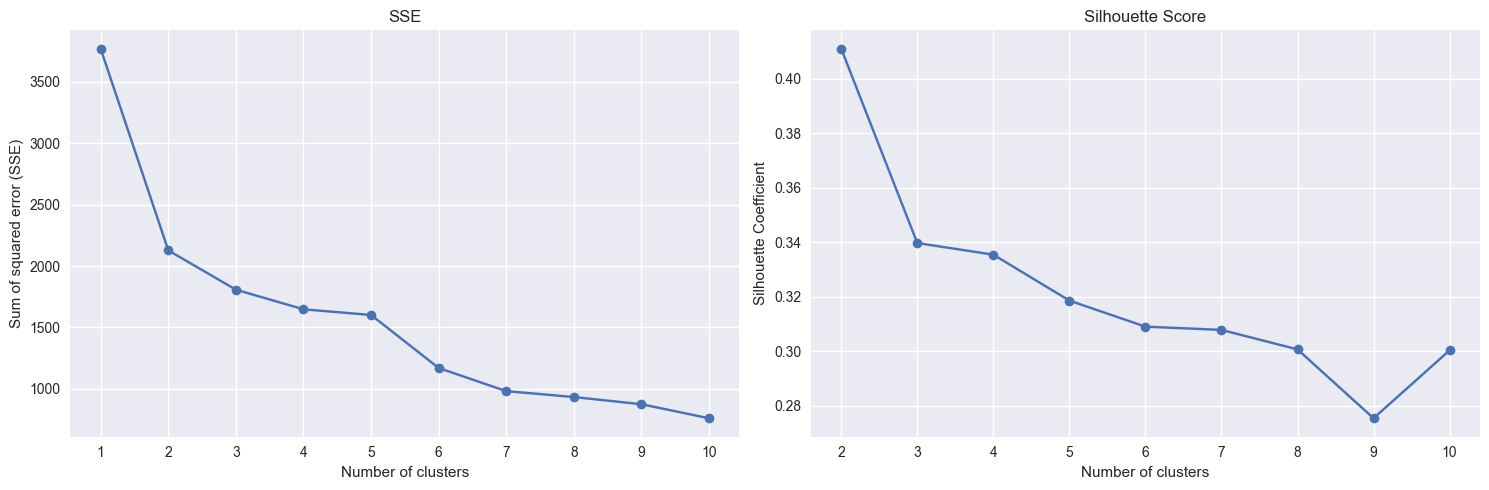

In [195]:
num_clusters = 10
gwp_sses = kmeans_elbow(X_gwp, num_clusters=num_clusters, seed=SEED)
gwp_silhouette_scores = kmeans_silhouette(X_gwp, num_clusters=num_clusters, seed=SEED)
plt.style.use('seaborn-v0_8')
plot_side_by_side(
    lambda: plot_cluster_sses(gwp_sses),
    lambda: plot_cluster_silhouettes(gwp_silhouette_scores),
    titles=["SSE", "Silhouette Score"],
)


In [228]:
cluster_pipeline = Pipeline(
    [
        ("pca", PCA(n_components=2, random_state=SEED)),
        ("kmeans",
           KMeans(
               n_clusters=2,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=SEED,),
       ),
    ]
)

cluster_pipeline.fit(X_gwp)

X_gwp_pca = cluster_pipeline["pca"].transform(X_gwp)

gwp_pred_labels = cluster_pipeline["kmeans"].labels_

gwp_silhoutte = silhouette_score(X_gwp_pca, gwp_pred_labels)
gwp_ari = adjusted_rand_score(y_gwp, gwp_pred_labels)

print(f"GWP Silhouette Score: {gwp_silhoutte}")
print(f"GWP Adjusted Rand Index: {gwp_ari}")

GWP Silhouette Score: 0.5952724092778283
GWP Adjusted Rand Index: 0.002689279693121489


/Users/nickolaitchesnokov/Desktop/Code/Projects/data_mining/.venv/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


In [229]:
# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, random_state=SEED)
X_gwp_tsne = tsne.fit_transform(X_gwp)

# Perform clustering with k-means
kmeans = KMeans(
    n_clusters=2, 
    init="k-means++", 
    n_init='auto', 
    random_state=SEED)

kmeans.fit(X_gwp_tsne)

# Get the predicted labels
gwp_tsne_labels = kmeans.labels_

gwp_silhoutte = silhouette_score(X_gwp_tsne, gwp_tsne_labels)
gwp_ari = adjusted_rand_score(y_gwp, gwp_tsne_labels)

print(f"GWP Silhouette Score: {gwp_silhoutte}")
print(f"GWP Adjusted Rand Index: {gwp_ari}")


GWP Silhouette Score: 0.37894096970558167
GWP Adjusted Rand Index: 0.0017102918720099506


/Users/nickolaitchesnokov/Desktop/Code/Projects/data_mining/.venv/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


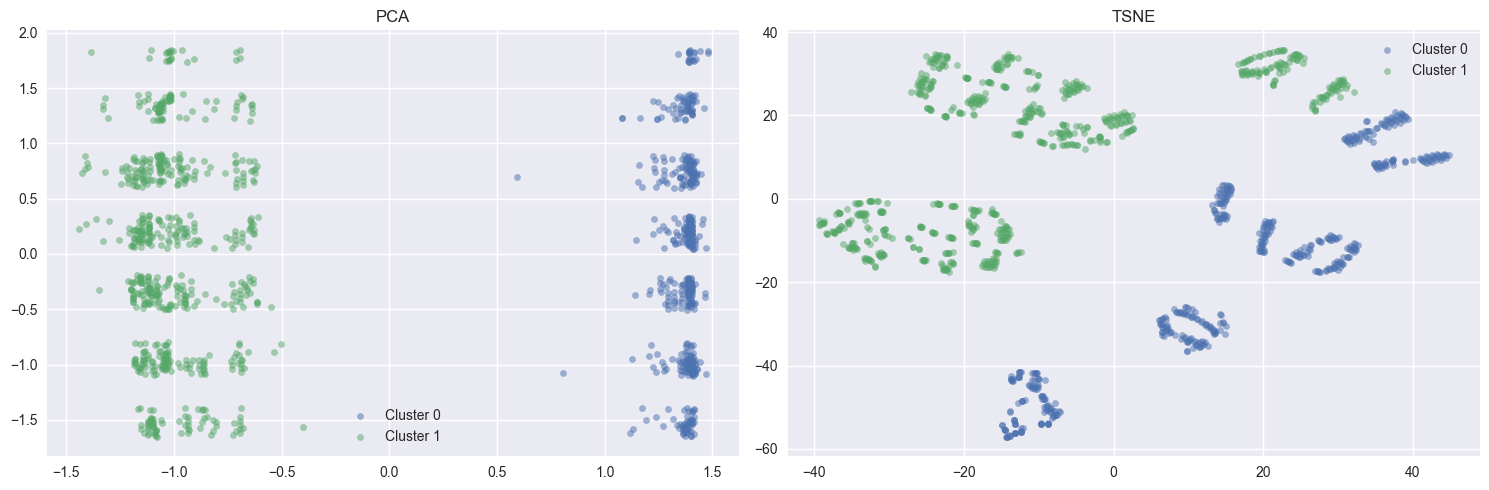

In [230]:
plot_side_by_side(
    lambda: plot_clusters(X_gwp_pca, gwp_pred_labels, "Clustering results for GWP data"),
    lambda: plot_clusters(X_gwp_tsne, gwp_tsne_labels, "Clustering results for GWP data (t-SNE)"),
    titles=["PCA", "TSNE"],
)

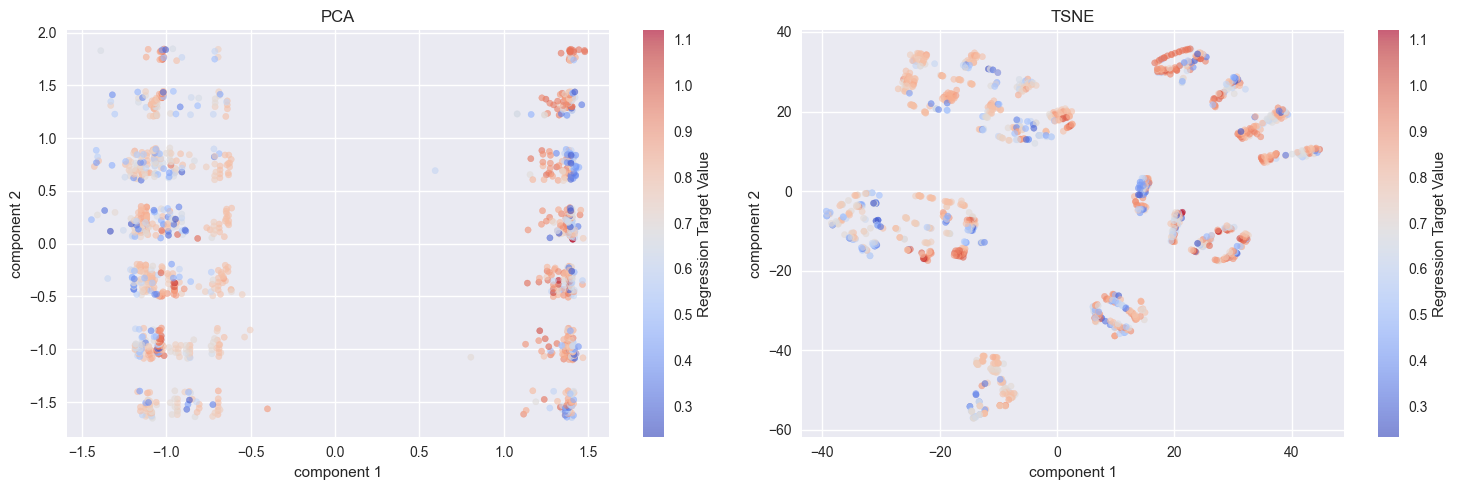

In [199]:
plot_side_by_side(
    lambda: plot_2d_data_heatscatter(X_gwp_pca, y_gwp),
    lambda: plot_2d_data_heatscatter(X_gwp_tsne, y_gwp),
    titles=["PCA", "TSNE"],
)

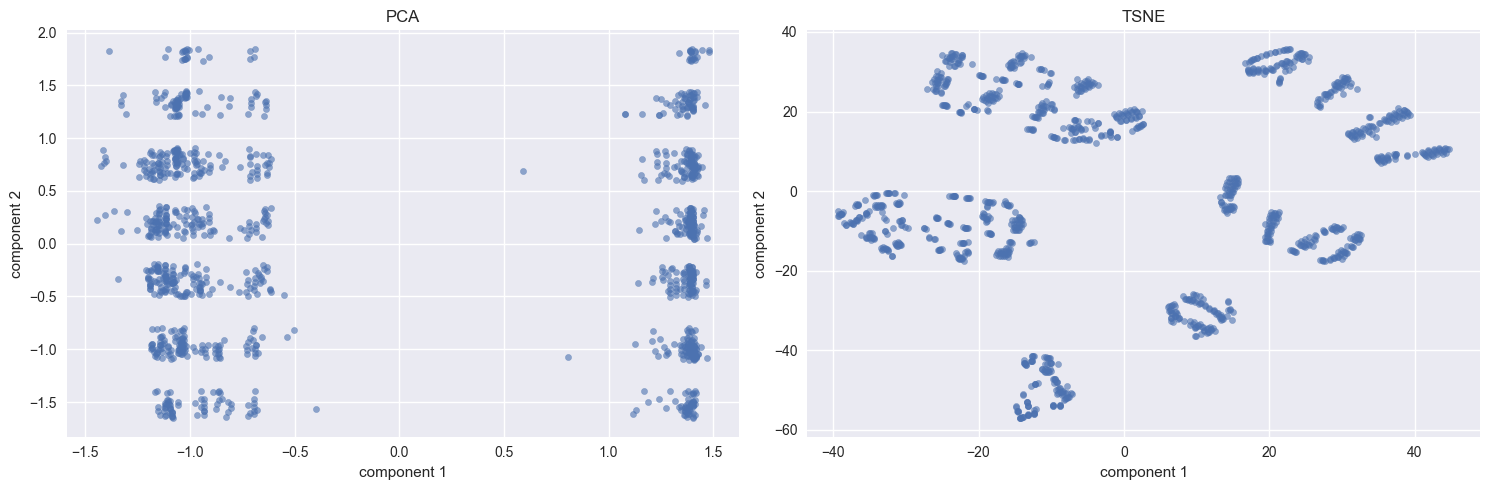

In [201]:
plot_side_by_side(
    lambda: plot_2d_data_scatter(X_gwp_pca),
    lambda: plot_2d_data_scatter(X_gwp_tsne),
    titles=["PCA", "TSNE"],
)

## Star Clustering

### K-means: Elbow method & Silhouette coefficient



In [58]:
num_clusters = 10
star_sses = kmeans_elbow(X_star, num_clusters=num_clusters, seed=SEED)
star_silhouette_scores = kmeans_silhouette(X_star, num_clusters=num_clusters, seed=SEED)


From the plots below:
- "Elbow" point = 4 clusters.
- Highest coefficient point = 4 clusters

Optimum number of clusters for GWP data seems to be 4. 

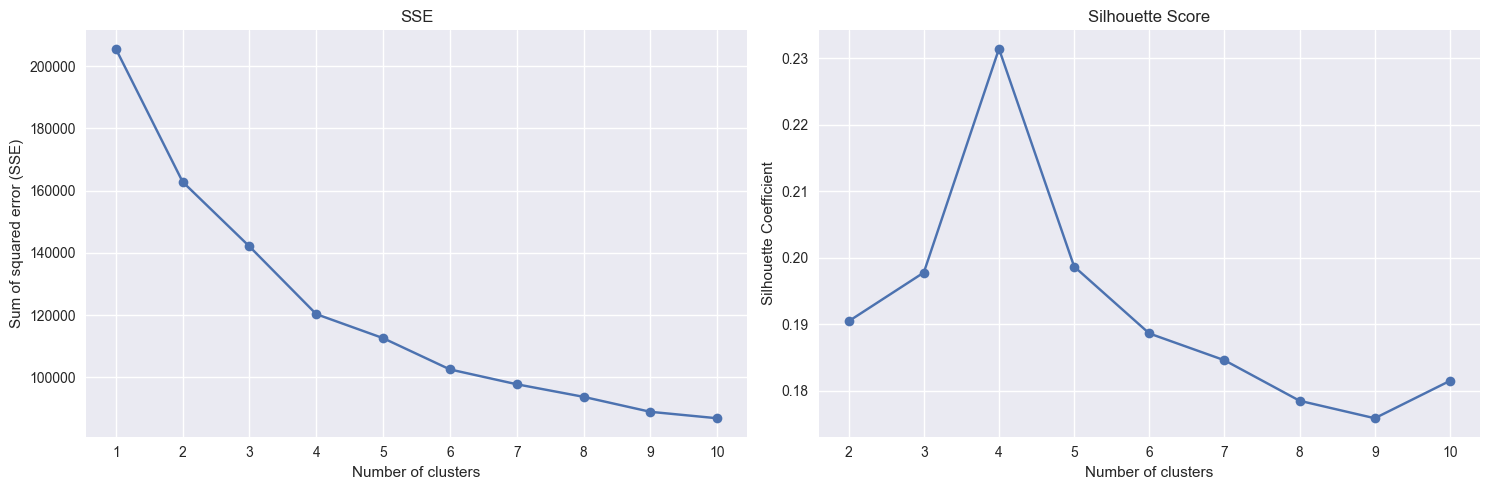

In [116]:
plot_side_by_side(
    lambda: plot_cluster_sses(star_sses),
    lambda: plot_cluster_silhouettes(star_silhouette_scores),
    titles=["SSE", "Silhouette Score"],
)

In [231]:

# number of clusters equals length of unique values in target
num_clusters = len(np.unique(y_star))

cluster_pipeline = Pipeline(
    [
        ("pca", PCA(n_components=2, random_state=SEED)),
        ("kmeans",
           KMeans(
               n_clusters=num_clusters,
               init="k-means++",
               n_init='auto',
               random_state=SEED,),
       ),
    ]
)

cluster_pipeline.fit(X_star)

X_star_pca = cluster_pipeline["pca"].transform(X_star)
star_pred_labels = cluster_pipeline["kmeans"].labels_

star_silhoutte = silhouette_score(X_star_pca, star_pred_labels)
star_ari = adjusted_rand_score(y_star, star_pred_labels)

print(f"STAR Silhouette Score: {star_silhoutte}")
print(f"STAR Adjusted Rand Index: {star_ari}")

STAR Silhouette Score: 0.4509372488654034
STAR Adjusted Rand Index: 0.02487765138951185


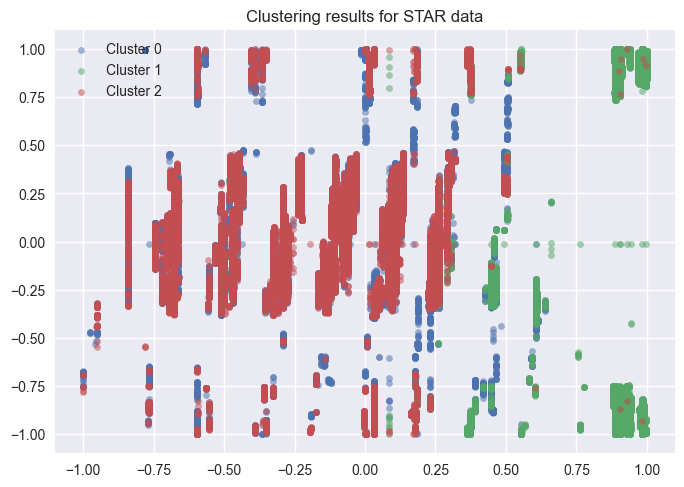

In [234]:
plot_clusters(X_star_pca, star_pred_labels, "Clustering results for STAR data")

#### Markdown Question: 
**Question**: Between clustering and classification algorithms, which one performed better for star dataset. Justify your answer.